In [1]:
import torch


In [2]:
bn_ir_ada = torch.load('C:/Users/vladi/RP/InterWild/demo/BN_outputs_IR_AdaBN.pt', map_location='cpu')

C:\Users\vladi\AppData\Local\Temp\ipykernel_40648\395812479.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bn_ir_ada = torch.load('C:/Users/vladi/RP/InterWild/demo/BN_o

In [2]:
bn_ir_no_ada = torch.load('C:/Users/vladi/RP/InterWild/demo/BN_outputs_IR_noAdaBN.pt', map_location='cpu')

C:\Users\vladi\AppData\Local\Temp\ipykernel_32632\306761548.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bn_ir_no_ada = torch.load('C:/Users/vladi/RP/InterWild/demo/B

In [3]:
bn_rgb_ada = torch.load('C:/Users/vladi/RP/InterWild/demo/BN_outputs_RGB_AdaBN.pt', map_location='cpu')


C:\Users\vladi\AppData\Local\Temp\ipykernel_40648\1283911333.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bn_rgb_ada = torch.load('C:/Users/vladi/RP/InterWild/demo/BN

In [3]:
bn_rgb_no_ada = torch.load('C:/Users/vladi/RP/InterWild/demo/BN_outputs_RGB_noAdaBN.pt', map_location='cpu')


C:\Users\vladi\AppData\Local\Temp\ipykernel_32632\1805680611.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bn_rgb_no_ada = torch.load('C:/Users/vladi/RP/InterWild/demo

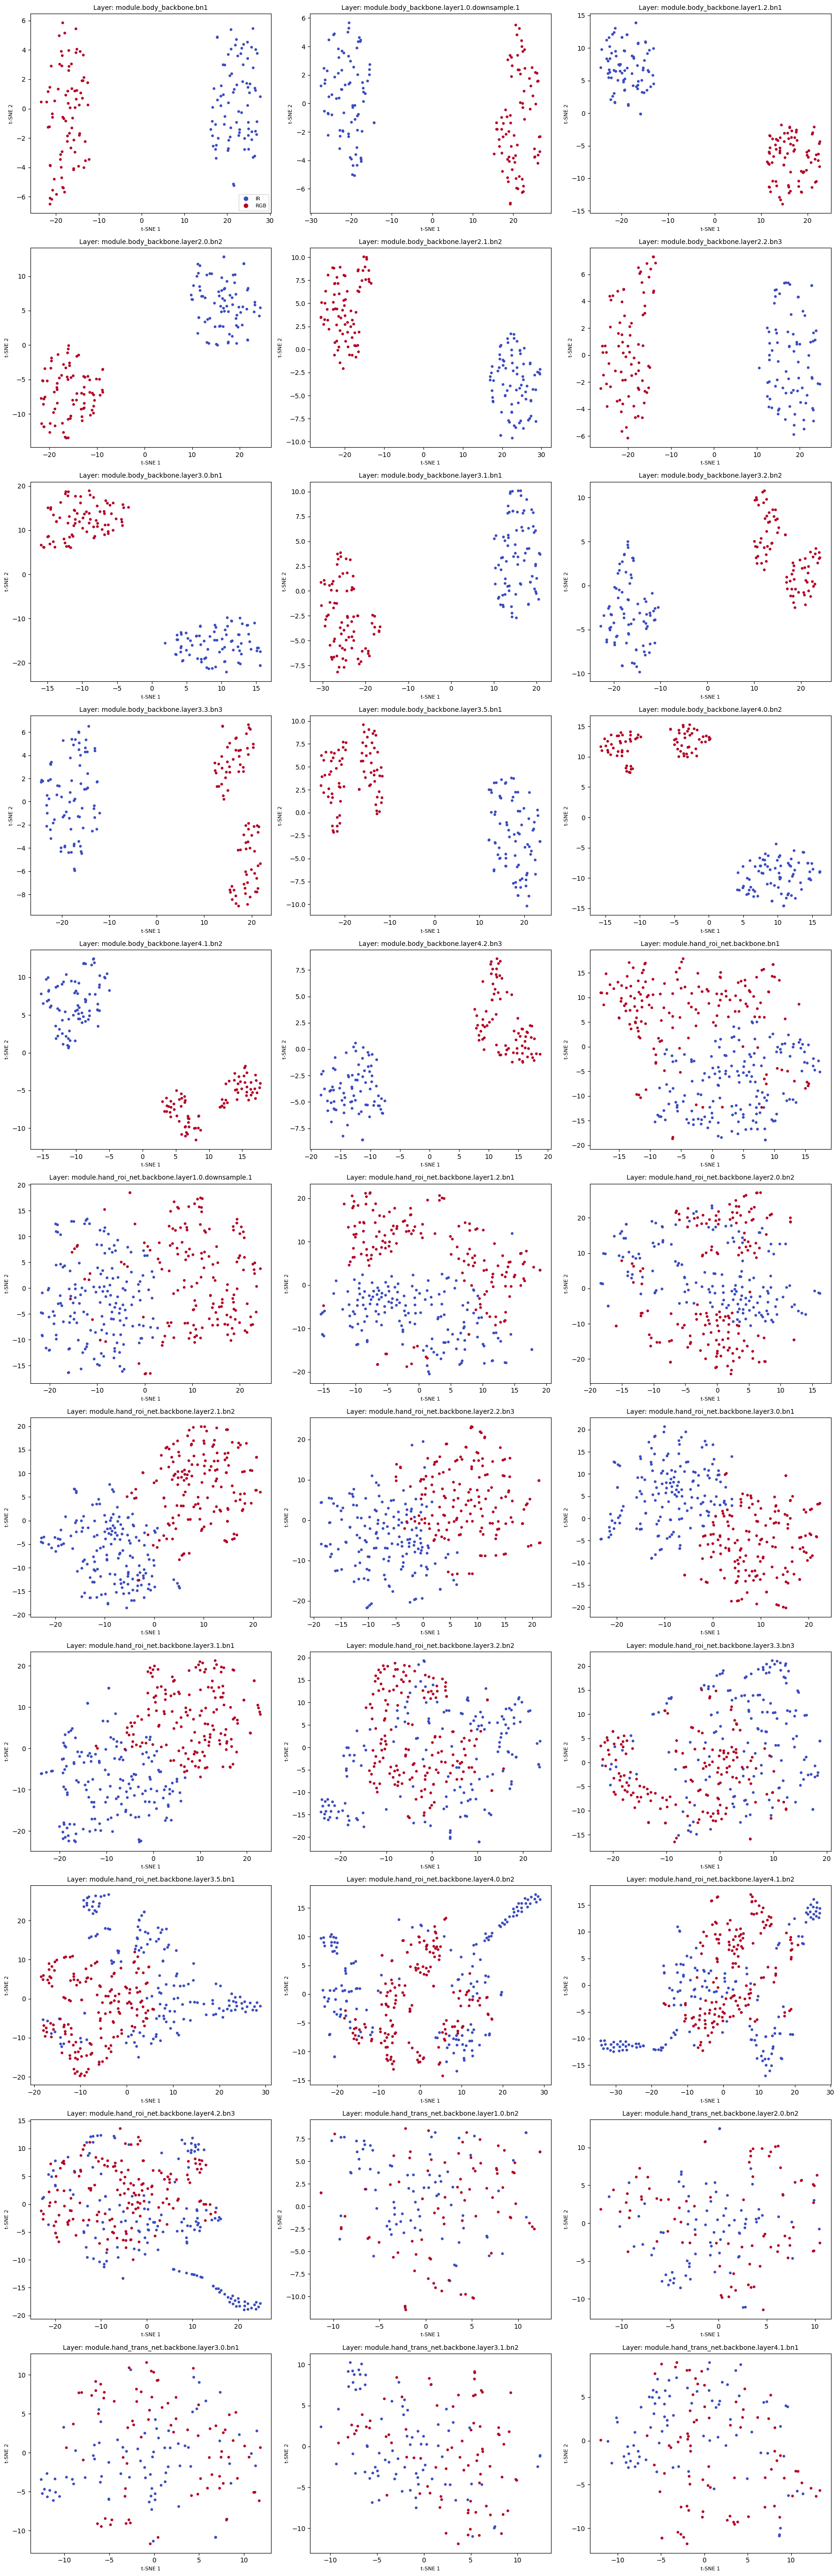

In [4]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline  # Add this import

layer_keys = bn_ir_ada.keys()

# Calculate grid layout
n_layers = len(layer_keys)
n_cols = 3
n_rows = (n_layers + n_cols - 1) // n_cols

plt.figure(figsize=(6*n_cols, 5*n_rows))

# Create t-SNE visualization for each layer
for idx, layer_key in enumerate(layer_keys):
    try:
        # Reduce maximum samples even further
        max_samples = 500  # Reduced from 1000
        
        ir_layer = [sample for batch in bn_ir_ada[layer_key] for sample in batch]
        rgb_layer = [sample for batch in bn_rgb_ada[layer_key] for sample in batch]
        
        # More aggressive sampling
        if len(ir_layer) + len(rgb_layer) > max_samples:
            ir_indices = np.random.choice(len(ir_layer), max_samples//2, replace=False)
            rgb_indices = np.random.choice(len(rgb_layer), max_samples//2, replace=False)
            ir_layer = [ir_layer[i] for i in ir_indices]
            rgb_layer = [rgb_layer[i] for i in rgb_indices]
        
        # Flatten and convert to numpy with immediate cleanup
        ir_flattened = np.vstack([tensor.reshape(-1).numpy() for tensor in ir_layer])
        del ir_layer
        rgb_flattened = np.vstack([tensor.reshape(-1).numpy() for tensor in rgb_layer])
        del rgb_layer
        
        # Stack and create labels
        X = np.vstack([ir_flattened, rgb_flattened])
        del ir_flattened, rgb_flattened
        labels = np.array([0]*(X.shape[0]//2) + [1]*(X.shape[0]//2))
        
        # First reduce dimensionality with PCA, then apply t-SNE
        pipeline = Pipeline([
            ('pca', PCA(n_components=min(50, X.shape[1]))),  # Reduce to 50 dimensions first
            ('tsne', TSNE(
                n_components=2,
                perplexity=min(30, len(X) - 1),
                max_iter=1000,  # Updated from n_iter
                n_jobs=-1,
                verbose=0
            ))
        ])
        
        X_transformed = pipeline.fit_transform(X)
        del X
        
        # Create subplot
        plt.subplot(n_rows, n_cols, idx + 1)
        scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], 
                            c=labels, cmap='coolwarm', s=10)
        
        # Add title and labels
        layer_name = layer_key # Simplified layer name
        plt.title(f'Layer: {layer_name}', fontsize=10)
        plt.xlabel('t-SNE 1', fontsize=8)
        plt.ylabel('t-SNE 2', fontsize=8)
        
        if idx == 0:
            plt.legend(handles=scatter.legend_elements()[0], 
                      labels=['IR', 'RGB'], 
                      fontsize=8)
        
        del X_transformed
        
    except Exception as e:
        print(f"Error processing layer {layer_key}: {str(e)}")
        continue

plt.tight_layout()
plt.show()